# GAN para generación de dígitos hablados
Este proyecto implementa una Red Generativa Antagónica (GAN) para generar audios de dígitos del 0 al 9 usando el dataset `spoken_digit`.

Incluye:
- Preprocesamiento con normalización y eliminación de silencio
- Modelo condicional (entrada: dígito one-hot)
- Entrenamiento con Wasserstein Loss
- Visualización de espectrogramas y formas de onda
- Guardado de checkpoints y logging con Weights & Biases (wandb)

In [1]:
# === Librerías del sistema y utilidades ===
import os
import sys
import glob
import json
import time
from datetime import timedelta

# === Librerías científicas ===
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean

# === Librerías de audio ===
import librosa
import librosa.display
import soundfile as sf

# === TensorFlow y datasets ===
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models

# === Visualización interactiva en notebooks ===
import IPython.display as ipd
from IPython.display import Audio, display

# === W&B para logging del entrenamiento ===
import wandb

# === Configuración para ocultar warnings de TensorFlow ===
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel('ERROR')

os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"

2025-04-27 18:27:26.972584: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-27 18:27:27.032910: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745800047.073891  226607 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745800047.081765  226607 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745800047.147993  226607 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

## Configuración de Weights & Biases

In [2]:
wandb.init(project='gan-spoken-digit_tacotron', name='GAN-Audio-Final')

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: homero-sepulveda (homero-sepulveda-iteso) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


## Funciones de preprocesamiento

In [3]:
def normalize_audio(audio):
    audio = tf.cast(audio, tf.float32)  #fuerza a float32 desde el inicio
    max_val = tf.reduce_max(tf.abs(audio))
    eps = tf.constant(1e-6, dtype=tf.float32)
    return tf.cond(
        max_val > eps,
        lambda: audio / max_val,
        lambda: audio
    )

def remove_silence(audio, label, threshold=.05):

    frame_length = 80
    frame_step = 40

    energy = tf.signal.frame(tf.abs(audio), frame_length, frame_step)
    rms = tf.reduce_mean(energy, axis=1)
    rms = tf.cast(rms, tf.float32)

    kernel = tf.constant([1/3, 1/3, 1/3], dtype=tf.float32)
    smoothed = tf.nn.conv1d(
        rms[tf.newaxis, :, tf.newaxis],
        kernel[:, tf.newaxis, tf.newaxis],
        stride=1,
        padding='SAME'
    )[0, :, 0]

    indices = tf.where(smoothed > threshold)
    if tf.size(indices) == 0:
        return audio[:0], label

    start_frame = tf.cast(indices[0][0], tf.int64)
    end_frame = tf.cast(indices[-1][0], tf.int64)

    start_sample = start_frame * tf.cast(frame_step, tf.int64)
    end_sample = end_frame * tf.cast(frame_step, tf.int64) + tf.cast(frame_length, tf.int64)

    audio_len = tf.cast(tf.shape(audio)[0], tf.int64)  # forzar a int64
    end_sample = tf.minimum(end_sample, audio_len)

    return audio[start_sample:end_sample], label



def standardize_audio_length(audio, max_len):
    audio_len = tf.shape(audio)[0]
    return tf.pad(audio, [[0, max_len - audio_len]]) if audio_len < max_len else audio[:max_len]

## Carga y preprocesamiento del dataset

In [4]:
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
from speechbrain.inference.TTS import Tacotron2

# ========================
# 1. Cargar y filtrar dataset
# ========================
ds = tfds.load('spoken_digit', split='train', as_supervised=True)
ds = ds.filter(lambda audio, label: tf.equal(label, 9))

# ========================
# 2. Inicializar Tacotron2
# ========================
tacotron2_model = Tacotron2.from_hparams(source="speechbrain/tts-tacotron2-ljspeech", savedir="tmpdir_tts")

# ========================
# 3. Calcular longitud máxima después de remover silencio
# ========================
audio_list = []
max_len = 0

for audio, label in ds:
    audio = normalize_audio(audio)
    audio, _ = remove_silence(audio, label)
    audio_list.append(audio)
    audio_len = tf.shape(audio)[0]
    max_len = max(max_len, audio_len.numpy())

# ========================
# 4. Generar pares (mel_tacotron, audio_real)
# ========================
mel_list = []
final_audio_list = []

for audio in audio_list:
    # Estandarizar audio
    audio_std = standardize_audio_length(audio, max_len)
    final_audio_list.append(audio_std[..., tf.newaxis].numpy())  # (samples, 1)
    
    # Generar Mel desde "nine"
    mel_output, _, _ = tacotron2_model.encode_text("nine")
    mel_output = mel_output.detach().cpu().numpy().astype(np.float32)  # (1, 80, frames)
    mel_output = np.expand_dims(mel_output, axis=-1)  # (1, 80, frames, 1)
    mel_list.append(mel_output[0])  # (80, frames, 1)

# ========================
# 5. Crear Dataset final usando from_generator
# ========================
def generator():
    for mel, audio in zip(mel_list, final_audio_list):
        yield mel, audio

# Definir las formas dinámicas
output_signature = (
    tf.TensorSpec(shape=(80, None, 1), dtype=tf.float32),   # Mel-spectrograma
    tf.TensorSpec(shape=(None, 1), dtype=tf.float32)         # Audio real
)

train_dataset = tf.data.Dataset.from_generator(generator, output_signature=output_signature)

train_dataset = train_dataset.shuffle(64) \
                             .padded_batch(8, padded_shapes=([80, None, 1], [None, 1])) \
                             .prefetch(tf.data.AUTOTUNE)


/home/winte/linux_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
I0000 00:00:1745800055.247308  226607 gpu_process_state.cc:208] Using CUDA malloc Async allocator for GPU: 0
I0000 00:00:1745800055.248183  226607 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5520 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9
INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/home/winte/apps/deep_learning/proyectodeep/tmpdir_tts/hyperparams.yaml'
INFO:speechbrain.utils.fetching:Fetch custom.py: Fetching from HuggingFace Hub 'speechbrain/tts-tacotron2-ljspeech' if not cached
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in tmpdir_tts.
I

In [5]:
for mel_batch, audio_batch in train_dataset.take(1):
    print("Shape de Mel batch:", mel_batch.shape)
    print("Shape de Audio batch:", audio_batch.shape)


Shape de Mel batch: (8, 80, 52, 1)
Shape de Audio batch: (8, 6120, 1)


2025-04-27 18:28:41.878299: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


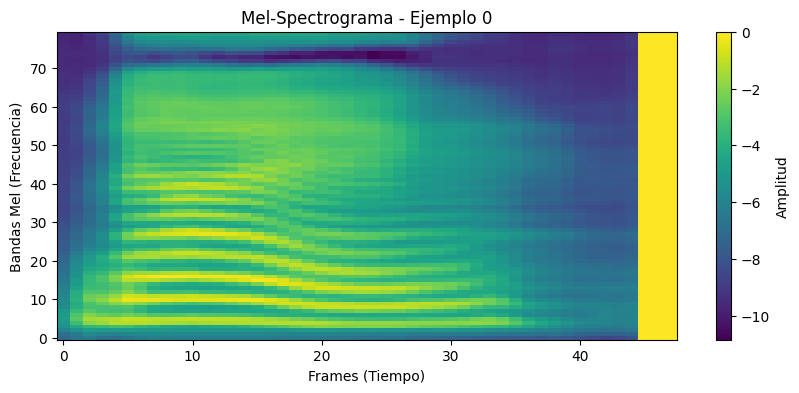

Audio correspondiente al ejemplo 0:


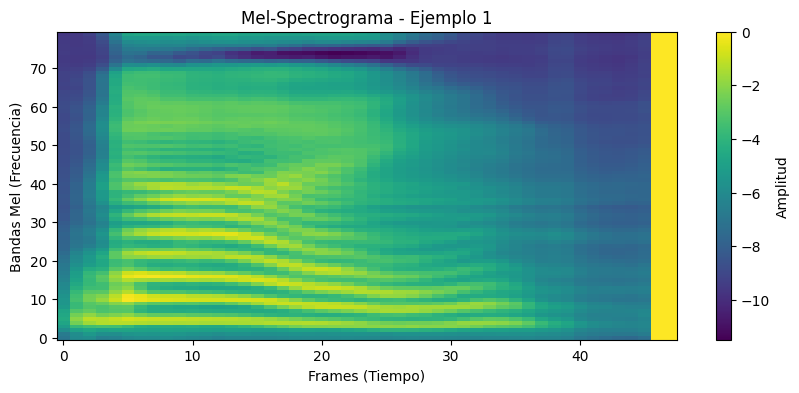

Audio correspondiente al ejemplo 1:


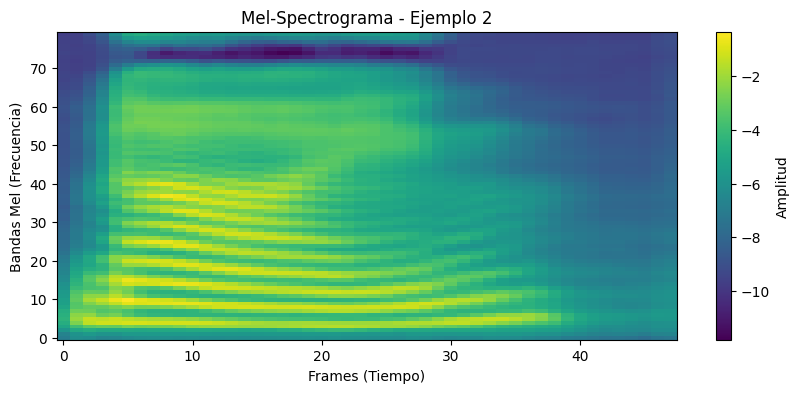

Audio correspondiente al ejemplo 2:


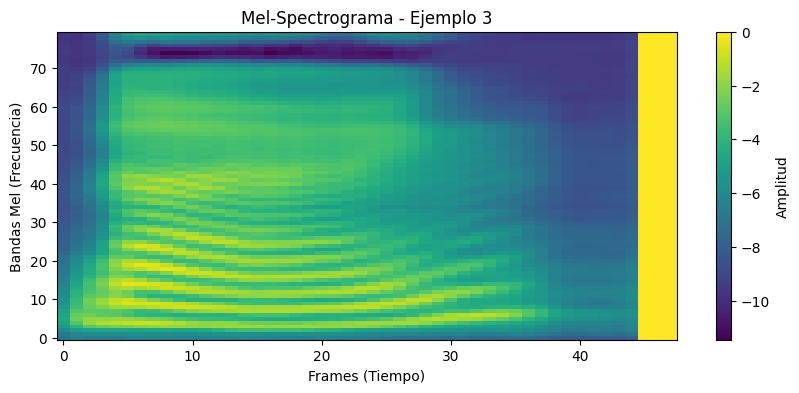

Audio correspondiente al ejemplo 3:


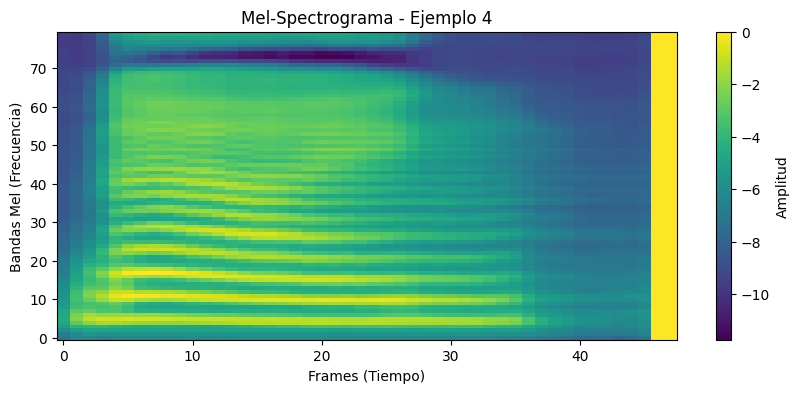

Audio correspondiente al ejemplo 4:


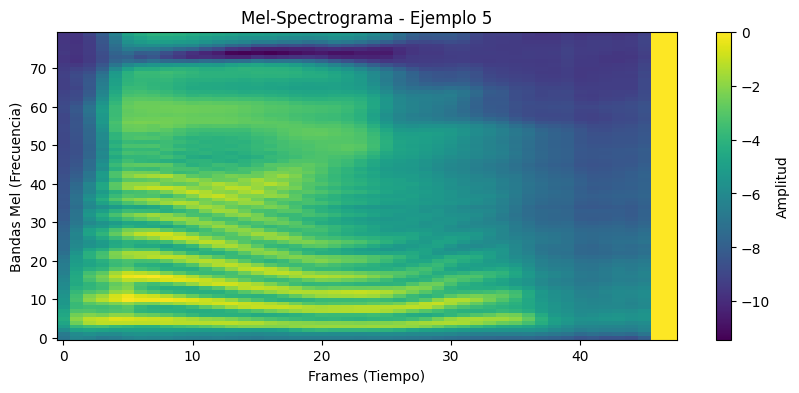

Audio correspondiente al ejemplo 5:


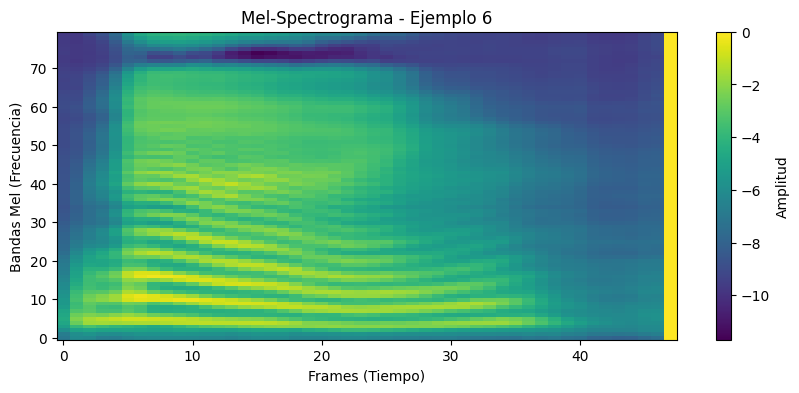

Audio correspondiente al ejemplo 6:


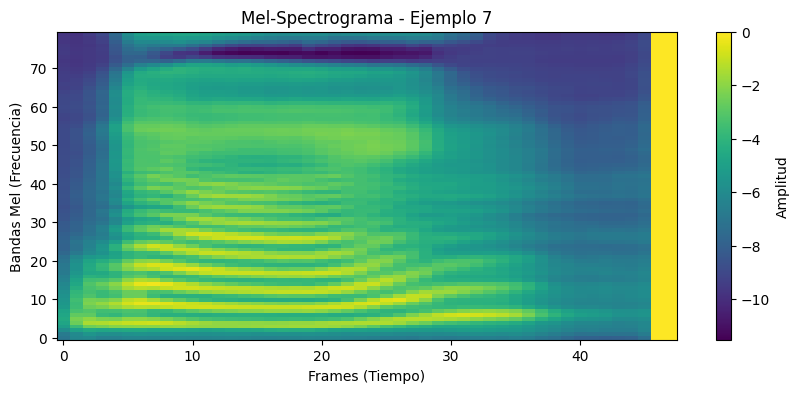

Audio correspondiente al ejemplo 7:


In [6]:
import matplotlib.pyplot as plt
import IPython.display as ipd

# Inspeccionar un batch del dataset
for mel_batch, audio_batch in train_dataset.take(1):
    batch_size = mel_batch.shape[0]
    
    for i in range(batch_size):
        mel = mel_batch[i].numpy().squeeze(-1)  # (80, frames)
        audio = audio_batch[i].numpy().squeeze()  # (samples,)

        # Graficar el Mel
        plt.figure(figsize=(10, 4))
        plt.imshow(mel, aspect='auto', origin='lower')
        plt.colorbar(label='Amplitud')
        plt.title(f'Mel-Spectrograma - Ejemplo {i}')
        plt.xlabel('Frames (Tiempo)')
        plt.ylabel('Bandas Mel (Frecuencia)')
        plt.show()

        # Escuchar el audio
        print(f'Audio correspondiente al ejemplo {i}:')
        ipd.display(ipd.Audio(audio, rate=8000))

    break  # Solo revisamos un batch

In [7]:
def show_waveforms_and_play(X_text, Y_audio, sample_rate=8000):
    num_samples = min(10, len(Y_audio))

    plt.figure(figsize=(16, 6))
    for i in range(num_samples):
        plt.subplot(2, 5, i + 1)
        plt.plot(Y_audio[i].flatten())
        plt.title("Dígito: 9")
        plt.xlabel("Tiempo")
        plt.ylabel("Amplitud")
        plt.grid(True)
    plt.tight_layout()
    plt.show()

    for i in range(num_samples):
        print("🔊 Reproduciendo dígito 9")
        display(Audio(Y_audio[i].flatten(), rate=sample_rate))

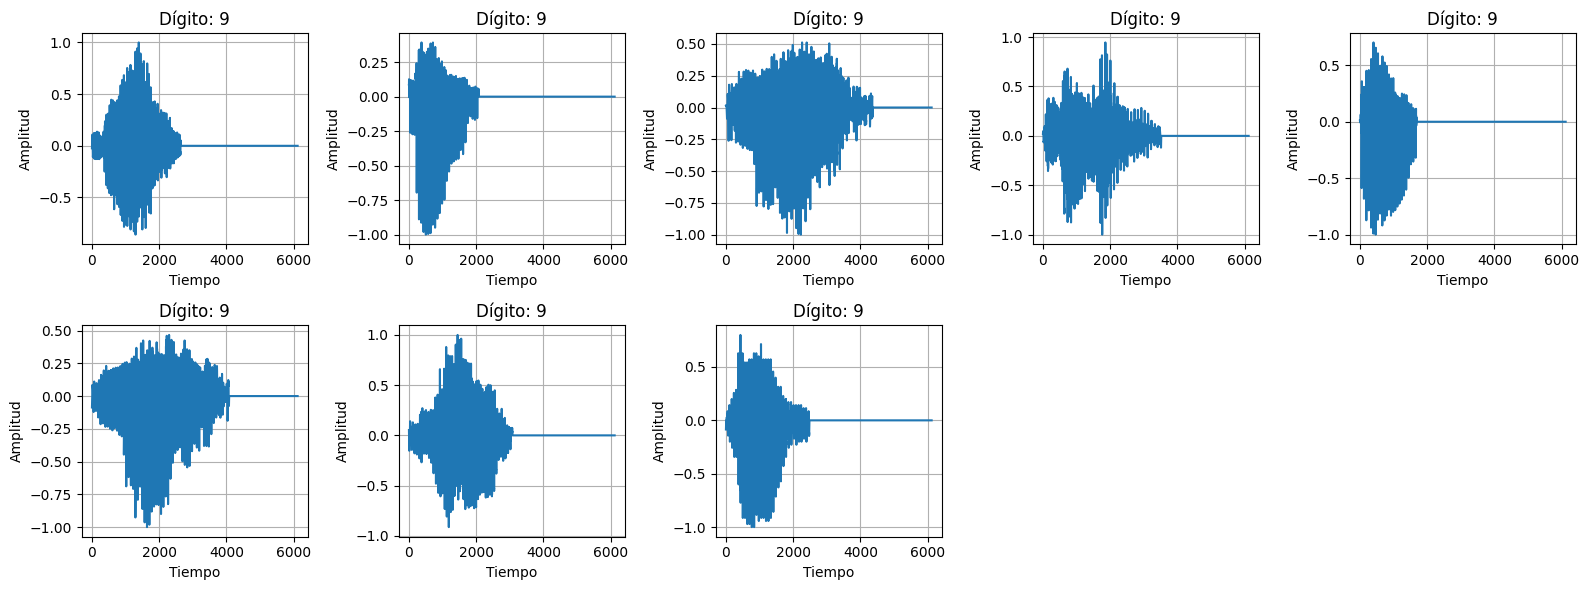

🔊 Reproduciendo dígito 9


🔊 Reproduciendo dígito 9


🔊 Reproduciendo dígito 9


🔊 Reproduciendo dígito 9


🔊 Reproduciendo dígito 9


🔊 Reproduciendo dígito 9


🔊 Reproduciendo dígito 9


🔊 Reproduciendo dígito 9


In [8]:
for X_batch, Y_batch in train_dataset.take(1):
    X_text = X_batch.numpy()
    Y_audio = Y_batch.numpy()
    show_waveforms_and_play(X_text, Y_audio)

In [9]:
import tensorflow as tf

def compute_mel_spectrogram(audio, sample_rate=8000, n_mels=80):
    # 1. Aplicar STFT
    stft = tf.signal.stft(audio, frame_length=256, frame_step=128)
    spectrogram = tf.abs(stft)

    # 2. Crear el banco de filtros Mel
    num_spectrogram_bins = spectrogram.shape[-1]
    linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins=n_mels,
        num_spectrogram_bins=num_spectrogram_bins,
        sample_rate=sample_rate,
        lower_edge_hertz=80.0,
        upper_edge_hertz=sample_rate / 2
    )

    # 3. Aplicar la transformación a Mel
    mel_spectrogram = tf.matmul(spectrogram, linear_to_mel_weight_matrix)
    
    # 4. (opcional) Convertir a dB
    log_mel_spectrogram = tf.math.log(mel_spectrogram + 1e-6)
    
    return log_mel_spectrogram

In [10]:
import matplotlib.pyplot as plt
import tensorflow as tf
import IPython.display as ipd

def show_batch_waveform_mel_play(batch_mels, batch_audios, n=8, sample_rate=8000):
    for i in range(min(n, batch_mels.shape[0])):
        plt.figure(figsize=(12, 3))

        # --- Obtener y preparar el waveform correspondiente ---
        audio_wave = batch_audios[i]
        if len(audio_wave.shape) > 1:
            audio_wave = tf.squeeze(audio_wave, axis=-1)
        audio_wave = audio_wave.numpy() if isinstance(audio_wave, tf.Tensor) else audio_wave

        # --- Obtener y preparar el mel_spec correspondiente ---
        mel_spec = batch_mels[i]
        if len(mel_spec.shape) > 2:
            mel_spec = tf.squeeze(mel_spec, axis=-1)
        mel_spec = mel_spec.numpy() if isinstance(mel_spec, tf.Tensor) else mel_spec

        # --- Graficar ---
        plt.subplot(1, 2, 1)
        plt.plot(audio_wave)
        plt.title(f'Waveform {i}')
        plt.xlabel('Samples')
        plt.ylabel('Amplitude')

        plt.subplot(1, 2, 2)
        plt.imshow(mel_spec, aspect='auto', origin='lower')
        plt.title(f'Mel Spectrogram {i}')
        plt.xlabel('Frames')
        plt.ylabel('Mel bands')
        plt.colorbar(label='Log amplitude')

        plt.tight_layout()
        plt.show()

        # --- Reproducir audio correcto ---
        display(ipd.Audio(audio_wave, rate=sample_rate))


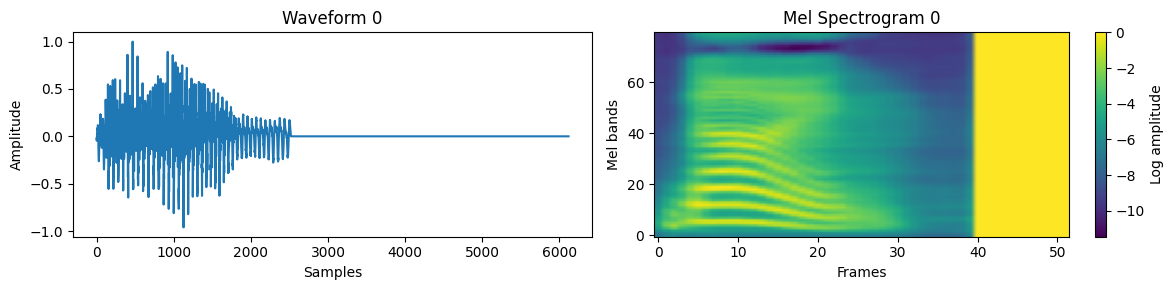

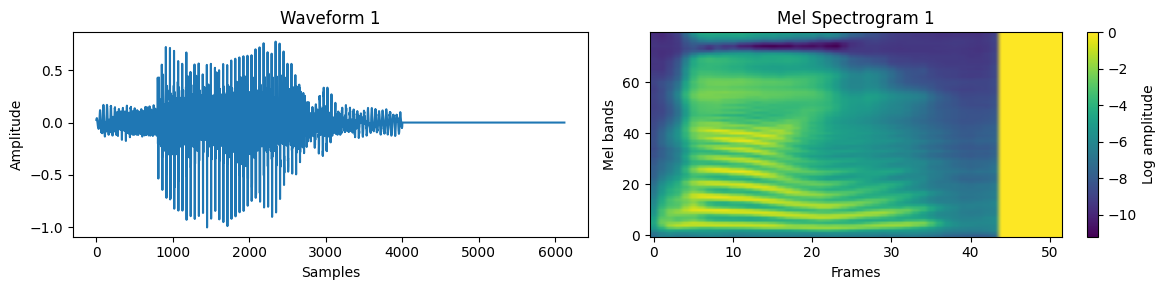

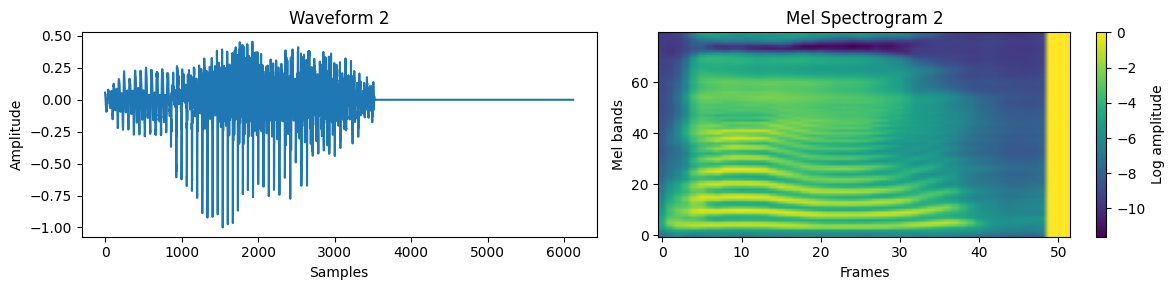

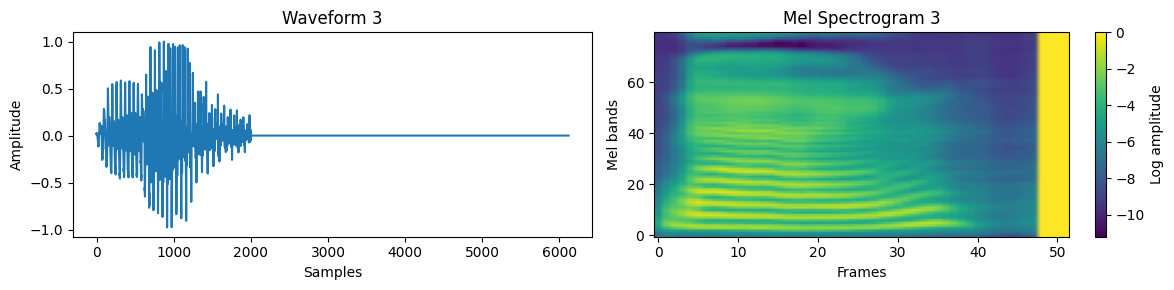

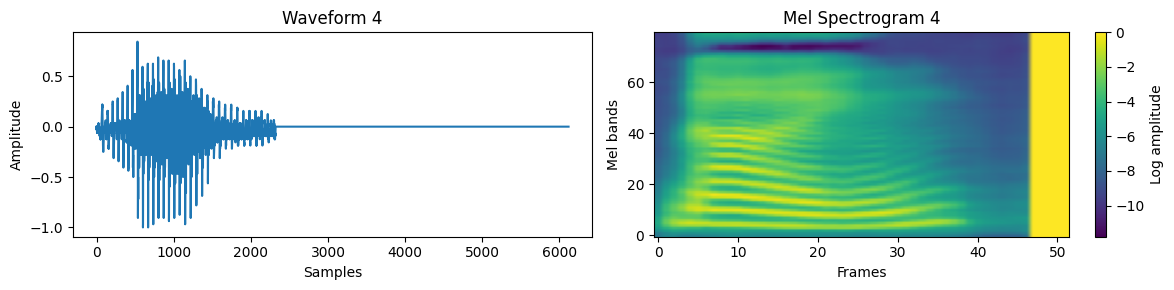

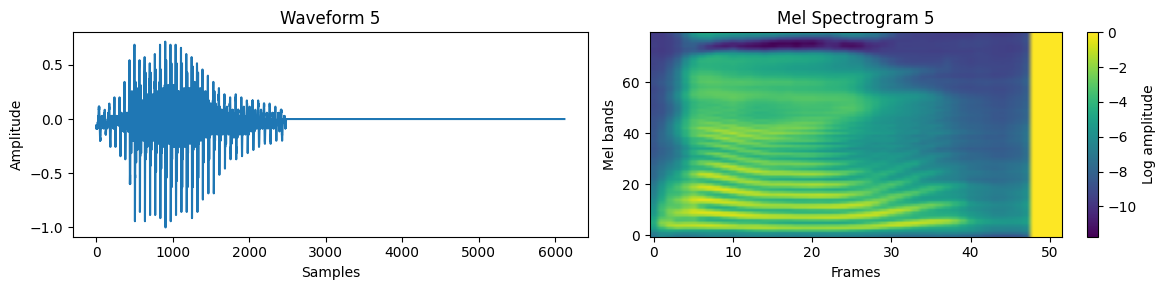

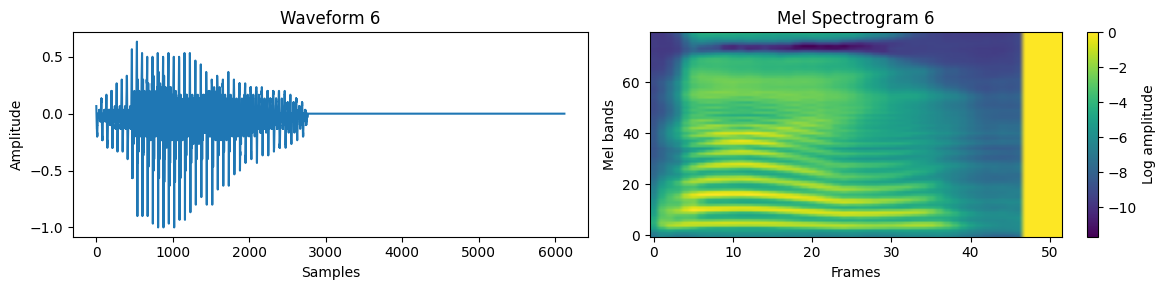

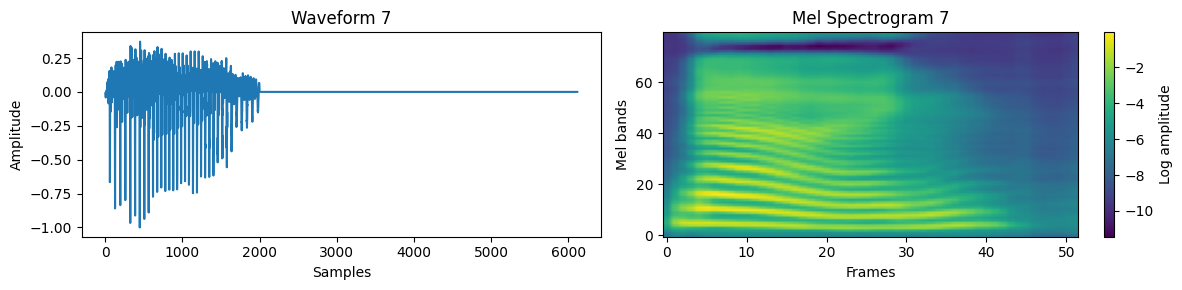

2025-04-27 18:28:45.159538: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [11]:
for X_batch, Y_batch in train_dataset.take(1):
    show_batch_waveform_mel_play(X_batch, Y_batch, n=8, sample_rate=8000)


## Definición del generador y discriminador y penalización de gradiente


In [12]:
def gradient_penalty(discriminator, real, fake):
    batch_size = tf.shape(real)[0]
    alpha = tf.random.uniform(shape=[batch_size] + [1] * (len(real.shape) - 1), minval=0.0, maxval=1.0)
    interpolated = real * alpha + fake * (1 - alpha)

    with tf.GradientTape() as tape:
        tape.watch(interpolated)
        pred = discriminator(interpolated)

    grads = tape.gradient(pred, interpolated)
    grads = tf.reshape(grads, [batch_size, -1])  # Aplana todas las dimensiones excepto batch
    norm = tf.norm(grads, axis=1)  # L2 norm
    penalty = tf.reduce_mean((norm - 1.0) ** 2)
    return penalty


In [13]:
noise_dim = 64  # Puedes ajustar este valor para más/menos variabilidad

def residual_block_1d(x, filters, kernel_size=3, strides=1):
    shortcut = x
    x = layers.Conv1D(filters, kernel_size, strides=strides, padding="same")(x)
    x = layers.LayerNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Conv1D(filters, kernel_size, strides=1, padding="same")(x)
    x = layers.LayerNormalization()(x)

    if shortcut.shape[-1] != filters or strides != 1:
        shortcut = layers.Conv1D(filters, 1, strides=strides, padding="same")(shortcut)

    x = layers.add([x, shortcut])
    x = layers.LeakyReLU(0.2)(x)
    return x

def build_generator_mel_to_wave_resnet(n_mels=80, upsample_scales=[2,2,2,2,2,2,2,2,2], channels=64):
    inputs = layers.Input(shape=(n_mels, None, 1))  # (batch, n_mels, frames, 1)

    x = layers.Permute((2, 1, 3))(inputs)  # (batch, frames, n_mels, 1)
    x = layers.Reshape((-1, n_mels))(x)    # (batch, frames, n_mels)

    for i, scale in enumerate(upsample_scales):
        x = layers.Conv1DTranspose(
            channels,
            kernel_size=scale * 2,
            strides=scale,
            padding="same"
        )(x)
        x = layers.LayerNormalization()(x)
        x = layers.LeakyReLU(0.2)(x)
        if i % 2 == 0:
            x = layers.GaussianNoise(0.01)(x)  # Ruido leve cada 2 bloques
        x = residual_block_1d(x, channels)

    outputs = layers.Conv1D(1, kernel_size=7, padding="same", activation="tanh")(x)

    return models.Model(inputs, outputs)

def build_discriminator_waveform_resnet(channels=64):
    inputs = layers.Input(shape=(None, 1))  # (batch, time, 1)

    x = inputs
    for i in range(5):
        filters = channels * (2 ** i)
        x = residual_block_1d(x, filters, strides=2)
        if i >= 2:
            x = layers.Dropout(0.1)(x)

    x = layers.GlobalAveragePooling1D()(x)
    outputs = layers.Dense(1)(x)  # Wasserstein output

    return models.Model(inputs, outputs)

In [14]:
generator = build_generator_mel_to_wave_resnet()
discriminator = build_discriminator_waveform_resnet()

batch_size = 32
optimizer_d = tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.0, beta_2=0.9)
optimizer_g = tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.0, beta_2=0.9)

In [15]:
for x_batch, y_batch in train_dataset.take(1):
    print(f'x_batch (Mel spectrogram): {x_batch.shape}')  # (batch_size, n_mels, frames, 1)
    print(f'y_batch (audio real): {y_batch.shape}')       # (batch_size, samples, 1)


x_batch (Mel spectrogram): (8, 80, 48, 1)
y_batch (audio real): (8, 6120, 1)


2025-04-27 18:30:10.547023: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 1 of 64
2025-04-27 18:30:10.561811: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


In [16]:
lambda_gp = 10.0
stft_loss_weight = 1.0

def multi_resolution_stft_loss(y_true, y_pred, fft_sizes=[256, 512, 1024], hop_sizes=[64, 128, 256]):
    loss = 0
    for fft, hop in zip(fft_sizes, hop_sizes):
        S_real = tf.abs(tf.signal.stft(y_true[..., 0], frame_length=fft, frame_step=hop))
        S_fake = tf.abs(tf.signal.stft(y_pred[..., 0], frame_length=fft, frame_step=hop))
        loss += tf.reduce_mean(tf.abs(S_real - S_fake))
    return loss / len(fft_sizes)

def gradient_penalty(discriminator, real, fake):
    batch_size = tf.shape(real)[0]
    alpha = tf.random.uniform([batch_size, 1, 1], 0.0, 1.0)
    interpolated = real * alpha + fake * (1.0 - alpha)

    with tf.GradientTape() as gp_tape:
        gp_tape.watch(interpolated)
        pred = discriminator(interpolated)
    grads = gp_tape.gradient(pred, interpolated)
    grads = tf.reshape(grads, [batch_size, -1])  # aplanar
    norm = tf.norm(grads, axis=1)
    return tf.reduce_mean((norm - 1.0) ** 2)

@tf.function
def train_step(mel_batch, real_audio):
    with tf.GradientTape() as d_tape, tf.GradientTape() as g_tape:
        fake_audio = generator(mel_batch, training=True)

        # Ajustar tamaño del fake_audio para coincidir con real_audio
        real_len = tf.shape(real_audio)[1]
        fake_len = tf.shape(fake_audio)[1]

        if fake_len > real_len:
            fake_audio = fake_audio[:, :real_len, :]
        elif fake_len < real_len:
            pad_size = real_len - fake_len
            fake_audio = tf.pad(fake_audio, [[0, 0], [0, pad_size], [0, 0]])

        # Normalizar audios antes de pasar al discriminador
        real_audio_for_disc = real_audio  # ya está normalizado si viene del dataset
        fake_audio_for_disc = fake_audio / (tf.reduce_max(tf.abs(fake_audio)) + 1e-12)

        # Salidas del discriminador
        real_out = discriminator(real_audio_for_disc, training=True)
        fake_out = discriminator(fake_audio_for_disc, training=True)

        # Opcional: aplicar clip para estabilizar (no obligatorio en WGAN-GP)
        real_out = tf.clip_by_value(real_out, -10.0, 10.0)
        fake_out = tf.clip_by_value(fake_out, -10.0, 10.0)

        # Discriminator loss (Wasserstein + Gradient Penalty)
        gp = gradient_penalty(discriminator, real_audio_for_disc, fake_audio_for_disc)
        d_loss = tf.reduce_mean(fake_out) - tf.reduce_mean(real_out) + lambda_gp * gp

        # Generator loss (Wasserstein + STFT loss)
        # Normalizar para STFT cálculo
        fake_audio_norm = fake_audio / (tf.reduce_max(tf.abs(fake_audio)) + 1e-12)
        real_audio_norm = real_audio / (tf.reduce_max(tf.abs(real_audio)) + 1e-12)
        stft_loss = multi_resolution_stft_loss(real_audio_norm, fake_audio_norm)

        g_loss = -tf.reduce_mean(fake_out) + stft_loss_weight * stft_loss

    # Calcular y aplicar gradientes
    d_grads = d_tape.gradient(d_loss, discriminator.trainable_variables)
    g_grads = g_tape.gradient(g_loss, generator.trainable_variables)

    optimizer_d.apply_gradients(zip(d_grads, discriminator.trainable_variables))
    optimizer_g.apply_gradients(zip(g_grads, generator.trainable_variables))

    return {
        "d_loss": d_loss,
        "g_loss": g_loss,
        "stft_loss": stft_loss
    }

## Configuración de checkpoints

In [17]:
checkpoint_dir = './checkpointstacotron'
os.makedirs(checkpoint_dir, exist_ok=True)

# Crear checkpoint incluyendo los optimizadores
generator_ckpt = tf.train.Checkpoint(generator=generator, optimizer=optimizer_g)
discriminator_ckpt = tf.train.Checkpoint(discriminator=discriminator, optimizer=optimizer_d)

# Crear managers (opcional pero recomendado)
generator_manager = tf.train.CheckpointManager(generator_ckpt, os.path.join(checkpoint_dir, 'gen'), max_to_keep=5)
discriminator


<Functional name=functional_1, built=True>

## Función de entrenamiento con logging y checkpoint

## Visualización del espectrograma

In [18]:
def compute_mcd(real_audio, fake_audio, sr=8000, n_mfcc=13):
    # Asegurar tipo numpy
    if isinstance(real_audio, tf.Tensor):
        real_audio = real_audio.numpy()
    if isinstance(fake_audio, tf.Tensor):
        fake_audio = fake_audio.numpy()

    real_audio = real_audio.flatten()
    fake_audio = fake_audio.flatten()

    # Extraer MFCCs
    mfcc_real = librosa.feature.mfcc(y=real_audio, sr=sr, n_mfcc=n_mfcc)
    mfcc_fake = librosa.feature.mfcc(y=fake_audio, sr=sr, n_mfcc=n_mfcc)

    # Alinear frames
    min_frames = min(mfcc_real.shape[1], mfcc_fake.shape[1])
    mfcc_real = mfcc_real[:, :min_frames]
    mfcc_fake = mfcc_fake[:, :min_frames]

    # Calcular distancia Euclidiana frame a frame
    distances = [euclidean(mfcc_real[:, i], mfcc_fake[:, i]) for i in range(min_frames)]
    
    # Aplicar fórmula de MCD
    mcd = (10.0 / np.log(10)) * np.sqrt(2) * np.mean(distances)
    return mcd


## Entrenamiento completo
- Configuración dinámica de épocas y reanudación desde checkpoint
- Generación y subida de audios a wandb

In [ ]:
checkpoint_dir = './checkpointstacotron'
os.makedirs(checkpoint_dir, exist_ok=True)

# Verificar modelos guardados
keras_models = sorted(
    glob.glob(os.path.join(checkpoint_dir, 'generator_epoch_*.keras')),
    key=lambda x: int(os.path.splitext(x.split('_')[-1])[0])
)

start_epoch = 0

if keras_models:
    latest_model_path = keras_models[-1]
    start_epoch = int(os.path.splitext(latest_model_path.split('_')[-1])[0])
    print(f"📦 Se encontró modelo guardado en la época {start_epoch}.")
    
    while True:
        decision = input(f"¿Deseas continuar desde la época {start_epoch}? (s = sí / n = no / cancelar = abortar): ").strip().lower()
        if decision == 's':
            
            # Cargar modelos reales
            generator = tf.keras.models.load_model(os.path.join(checkpoint_dir, f'generator_epoch_{start_epoch}.keras'))
            discriminator = tf.keras.models.load_model(os.path.join(checkpoint_dir, f'discriminator_epoch_{start_epoch}.keras'))

            print(f"✅ Modelos cargados desde la época {start_epoch}.")
            break
        elif decision == 'n':
            print("🔁 Reiniciando desde época 0...")
            start_epoch = 0
            break
        elif decision == 'cancelar':
            sys.exit("⛔ Entrenamiento cancelado por el usuario.")
        else:
            print("❌ Entrada no válida. Escribe 's', 'n' o 'cancelar'.")
else:
    print("🆕 No se encontraron modelos guardados. Entrenamiento desde cero.")
    start_epoch = 0

# Definir cuántas épocas entrenar
while True:
    entrada = input("¿Cuántas épocas deseas entrenar a partir de aquí? [Enter para usar 100]: ").strip()
    if entrada == "":
        total_epochs = 100
        break
    try:
        total_epochs = int(entrada)
        break
    except ValueError:
        print("❌ Por favor, ingresa un número válido.")

end_epoch = start_epoch + total_epochs
initial_time = time.time()
last_10_start = time.time()

for epoch in range(start_epoch, end_epoch):
    epoch_start = time.time()

    for mel_batch, real_audio in train_dataset:
        losses = train_step(mel_batch, real_audio)
        d_loss, g_loss, stft_loss = losses["d_loss"], losses["g_loss"], losses["stft_loss"]

    if (epoch + 1) % 10 == 0:
        elapsed = time.time() - last_10_start
        last_10_start = time.time()

        total_elapsed = time.time() - initial_time
        epochs_done = epoch + 1 - start_epoch
        avg_time_per_epoch = total_elapsed / epochs_done
        epochs_remaining = end_epoch - (epoch + 1)
        eta = timedelta(seconds=int(avg_time_per_epoch * epochs_remaining))

        print(f"Epoch {epoch + 1} | D Loss: {d_loss:.6f} | G Loss: {g_loss:.6f} | STFT Loss: {stft_loss:.6f}")
        print(f"🕒 Tiempo en estas 10 épocas: {elapsed:.2f}s | ETA: {eta}")

        # Generar muestra
        for mel_batch_sample, real_audio_sample in train_dataset.take(1):
            generated_audio = generator(mel_batch_sample[:1], training=False)

            # Ajustar tamaño del audio generado
            real_len = tf.shape(real_audio_sample[:1])[1]
            fake_len = tf.shape(generated_audio)[1]
            if fake_len > real_len:
                generated_audio = generated_audio[:, :real_len, :]
            elif fake_len < real_len:
                pad_size = real_len - fake_len
                generated_audio = tf.pad(generated_audio, [[0, 0], [0, pad_size], [0, 0]])

            # Convertir a numpy y normalizar
            generated_audio = tf.squeeze(generated_audio, axis=-1).numpy()[0]
            generated_audio = generated_audio / np.max(np.abs(generated_audio)) if np.max(np.abs(generated_audio)) > 0 else generated_audio

            real_audio_np = tf.squeeze(real_audio_sample[0], axis=-1).numpy()

            # Calcular MCD
            mcd_value = compute_mcd(real_audio=real_audio_np, fake_audio=generated_audio)

            d_loss_val = float(d_loss.numpy())
            g_loss_val = float(g_loss.numpy())
            stft_loss_val = float(stft_loss.numpy())

            wandb.log({
                "D Loss": d_loss_val,
                "G Loss": g_loss_val,
                "STFT Loss": stft_loss_val,
                "epoch": epoch + 1,
                "tiempo_últimas_10_epocas_s": elapsed,
                "mcd": mcd_value,
                f"audio_epoca_{epoch + 1}": [wandb.Audio(generated_audio, sample_rate=8000, caption=f"Epoca {epoch+1}")]
            })

    if (epoch + 1) % 100 == 0:
        # Guardar modelos
        generator.save(os.path.join(checkpoint_dir, f"generator_epoch_{epoch + 1}.keras"))
        discriminator.save(os.path.join(checkpoint_dir, f"discriminator_epoch_{epoch + 1}.keras"))

print('✅ Entrenamiento terminado.')

# Guardar modelos finales
generator.save(os.path.join(checkpoint_dir, f'generator_epoch_{end_epoch}.keras'))
discriminator.save(os.path.join(checkpoint_dir, f'discriminator_epoch_{end_epoch}.keras'))
print(f'✅ Modelos guardados hasta la época {end_epoch}')


📦 Se encontró modelo guardado en la época 1000.
❌ Entrada no válida. Escribe 's', 'n' o 'cancelar'.
✅ Modelos cargados desde la época 1000.


/home/winte/linux_env/lib/python3.12/site-packages/tensorflow/python/autograph/pyct/inspect_utils.py:118: UserWarning: Module 'speechbrain.pretrained' was deprecated, redirecting to 'speechbrain.inference'. Please update your script. This is a change from SpeechBrain 1.0. See: https://github.com/speechbrain/speechbrain/releases/tag/v1.0.0
  if hasattr(m, '__file__') and m.__file__ == obj_file:
2025-04-27 18:43:41.799099: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [33]:
import tensorflow as tf
import numpy as np
import os
import soundfile as sf
import glob
from tensorflow import keras
from speechbrain.inference.TTS import Tacotron2

# === 1. Cargar Tacotron2 ===
tacotron2_model = Tacotron2.from_hparams(
    source="speechbrain/tts-tacotron2-ljspeech",
    savedir="tmpdir_tts",
    run_opts={"device": "cpu"}
)

# === 2. Cargar Generator desde el checkpoint más reciente ===
checkpoint_dir = "./checkpointstacotron"

def load_latest_generator_checkpoint(checkpoint_dir):
    checkpoint_files = sorted(
        glob.glob(os.path.join(checkpoint_dir, 'generator_epoch_*.keras')),
        key=lambda x: int(os.path.splitext(x.split('_')[-1])[0])
    )
    if not checkpoint_files:
        raise ValueError("❌ No se encontraron modelos en la carpeta de checkpoints.")
    
    latest_checkpoint = checkpoint_files[-1]
    print(f"✅ Usando checkpoint: {latest_checkpoint}")
    
    generator = keras.models.load_model(latest_checkpoint, compile=False)
    return generator

generator = load_latest_generator_checkpoint(checkpoint_dir)

# === 3. Generar Mel a partir de texto "nine" ===
text = "nine"
mel_output, _, _ = tacotron2_model.encode_text(text)
mel_output = mel_output.detach().cpu().numpy().astype(np.float32)  # (1, 80, frames)

# === 4. Asegurar 4 dimensiones ===
if mel_output.ndim == 3:
    mel_input = np.expand_dims(mel_output, axis=-1)  # (1, 80, frames, 1)
else:
    mel_input = mel_output

# === 5. Pasarlo por el Generator ===
generated_audio = generator(mel_input, training=False).numpy()[0, :, 0]

# === 6. Normalizar
generated_audio = generated_audio / (np.max(np.abs(generated_audio)) + 1e-12)

# === 6.5. Recortar a 1 segundo (8000 muestras)
generated_audio = generated_audio[:6120]

# === 7. Guardar audio
sf.write("audio_generado_nine.wav", generated_audio, samplerate=8000)

print("✅ Audio generado exitosamente y guardado como 'audio_generado_nine.wav'")


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/home/winte/apps/deep_learning/proyectodeep/tmpdir_tts/hyperparams.yaml'
INFO:speechbrain.utils.fetching:Fetch custom.py: Fetching from HuggingFace Hub 'speechbrain/tts-tacotron2-ljspeech' if not cached
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in tmpdir_tts.
INFO:speechbrain.utils.fetching:Fetch model.ckpt: Using symlink found at '/home/winte/apps/deep_learning/proyectodeep/tmpdir_tts/model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["model"] = /home/winte/apps/deep_learning/proyectodeep/tmpdir_tts/model.ckpt
INFO:speechbrain.utils.parameter_transfer:Loading pretrained files for: model
DEBUG:speechbrain.utils.parameter_transfer:Redirecting (loading from local path): model -> /home/winte/apps/deep_learning/proyectodeep/tmpdir_tts/model.ckpt


✅ Usando checkpoint: ./checkpointstacotron/generator_epoch_1000.keras
✅ Audio generado exitosamente y guardado como 'audio_generado_nine.wav'
